In [1]:
#Импорт библиотек для нашей работы
import pandas as pd #библиотека анализа данных с открытым исходным кодом
import numpy as np #библиотека для научных вычислений
import missingno as msno #библиотека которая помогает визуализировать недостающие данные в датафреймах Pandas
import seaborn as sns #библиотека визуализации данных Python, построенная поверх Matplotlib
import matplotlib.pyplot as plt #коллекция функций в стиле команд, которая позволяет использовать matplotlib почти так же, как MATLAB


#Игнорирование предупреждений
import warnings
warnings.filterwarnings("ignore")
# Чтение файлов обычно выглядит так:
df = pd.read_csv('gender_submission.csv')
test_data = pd.read_csv('test.csv')
print(test_data)
train_data = pd.read_csv('train.csv')
#Для изучения данных соединим train и test.
y = test_data.merge(df,on='PassengerId', how = 'right')
df = train_data.append(y)
#print(y)
#Классы билетов
df.groupby('Pclass')['PassengerId'].count()

     PassengerId  Pclass                                          Name  \
0            892       3                              Kelly, Mr. James   
1            893       3              Wilkes, Mrs. James (Ellen Needs)   
2            894       2                     Myles, Mr. Thomas Francis   
3            895       3                              Wirz, Mr. Albert   
4            896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)   
..           ...     ...                                           ...   
413         1305       3                            Spector, Mr. Woolf   
414         1306       1                  Oliva y Ocana, Dona. Fermina   
415         1307       3                  Saether, Mr. Simon Sivertsen   
416         1308       3                           Ware, Mr. Frederick   
417         1309       3                      Peter, Master. Michael J   

        Sex   Age  SibSp  Parch              Ticket      Fare Cabin Embarked  
0      male  34.5      0      0 

Pclass
1    323
2    277
3    709
Name: PassengerId, dtype: int64

In [2]:
#Мужчины-женщины на борту
df.groupby('Sex')['PassengerId'].count()

Sex
female    466
male      843
Name: PassengerId, dtype: int64

In [3]:
#Описательная статистика возраста пассажиров.
df.Age.describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

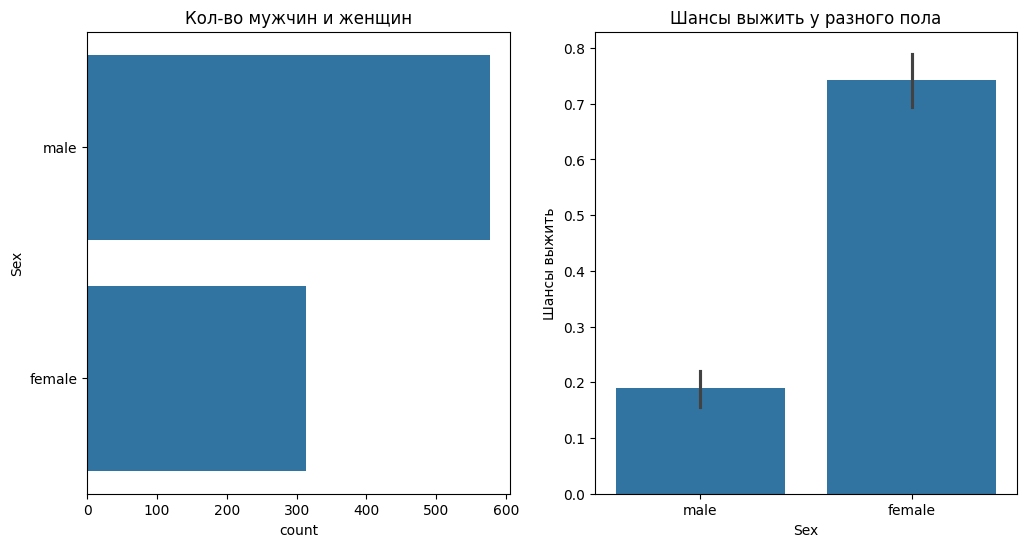

In [4]:
#Визуализация шансов выжить в зависимости от пола и общее кол-во мужчин и женщин
fig, axarr = plt.subplots(1, 2, figsize=(12,6))
a = sns.countplot(train_data['Sex'], ax=axarr[0]).set_title('Кол-во мужчин и женщин')
axarr[1].set_title('Шансы выжить у разного пола')
b = sns.barplot(x='Sex', y='Survived', data=train_data, ax=axarr[1]).set_ylabel('Шансы выжить')

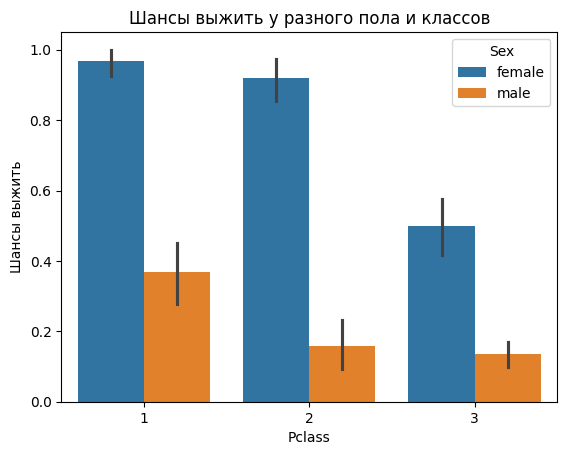

In [5]:
#Визуализация шансов выжить мужчин и женщин в зависимости от класса
plt.title('Шансы выжить у разного пола и классов')
g = sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train_data).set_ylabel('Шансы выжить')

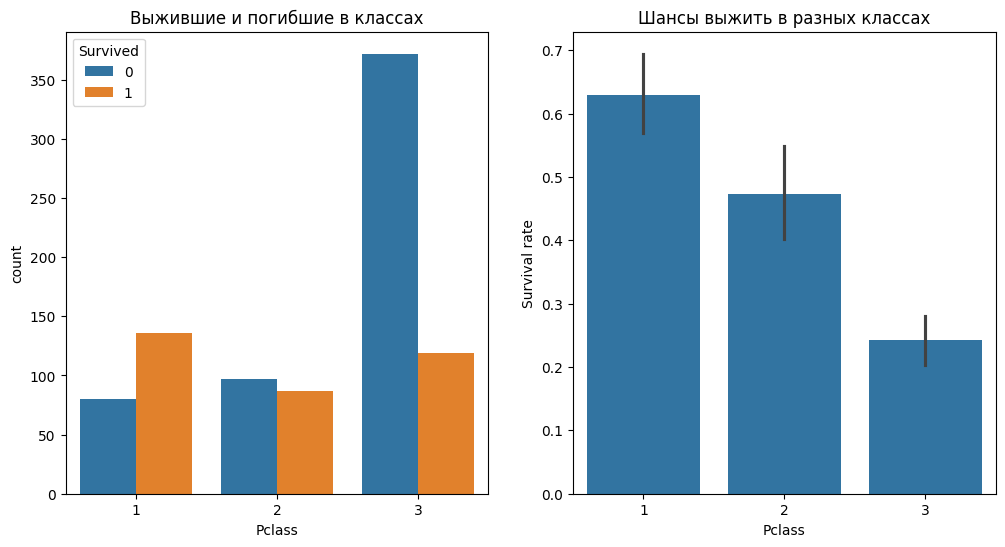

In [6]:
#Визуализация шансов выжить в зависимости от класса и общее кол-во выживших
fig, axarr = plt.subplots(1,2,figsize=(12,6))
a = sns.countplot(x='Pclass', hue='Survived', data=train_data, ax=axarr[0]).set_title('Выжившие и погибшие в классах')
axarr[1].set_title('Шансы выжить в разных классах')
b = sns.barplot(x='Pclass', y='Survived', data=train_data, ax=axarr[1]).set_ylabel('Survival rate')

С помощью команды AWK в линуксе нашли самое популярное имя на титанике - Anna

cat titanic.csv | awk -F "," '/(Mrs.|Miss.)/ {print $5}' | awk '{if ($1~/Miss./) {print $2} else {str=substr($0, index($0, "(")+1); if (str~/ /) {print substr(str, 1, index(str, " "))} else {print substr(str, 1, index(str, ")")-1) } } }' | tr -d [:punct: ] | sort | uniq -c | sort -rn | awk 'NR==2{print $2}'

# Создание классификаторов для предсказаний

In [61]:
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
mark="Survived"

Функция гармонизации данных

In [62]:
def harmonize_data(titanic):
    #Пропущенные значения возраста заменяются медианным значением возраста
    titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())
    titanic["Age"].median()


    #Кодирование переменной "Sex" в числовой формат
    titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
    titanic.loc[titanic["Sex"] == "female", "Sex"] = 1

    #Заполнение пропущенных значений переменной "Embarked" значением "S" и кодирование ее в числовой формат
    titanic["Embarked"] = titanic["Embarked"].fillna("S")

    titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
    titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
    titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2
#Пропущенные значения переменной "Fare" заменяются медианным значением стоимости билета:
    titanic["Fare"] = titanic["Fare"].fillna(titanic["Fare"].median())

    return titanic

In [63]:
#кросс-валидация модели
from sklearn.model_selection import cross_val_score

def validation_scores(clf, train_data):
    scores = cross_val_score(
        clf,
        train_data[predictors],
        train_data[mark],
        cv=3
    )
    return scores.mean()

In [64]:
train_data = harmonize_data(train_data)
test_data  = harmonize_data(test_data)

In [65]:
# Функция, которая сравнивает производительность нескольких классификаторов на обучающих данных
def compare_metods(classifiers, train_data):
    names, scores = [], []
    for name, clf in classifiers:
        names.append(name)
        scores.append(validation_scores(clf, train_data))
    return pd.DataFrame(scores, index=names, columns=['Scores'])

In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

Создание классификаторов

In [70]:
classifiers = [
    ("Nearest Neighbors", KNeighborsClassifier(3)), #метод к-ближайших соседей
    ("Linear SVM", SVC(kernel="linear", C=0.025)), #классификации линейных опорных векторов
    ("RBF SVM", SVC(gamma=2, C=1)), #метод опорных векторов
    ("Gaussian Process",GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True)), #функция логистической связи
    ("Decision Tree", DecisionTreeClassifier(max_depth=5)), #дерево решений
    ("Random Forest", RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)), #случайный лес
    ("Neural Net", MLPClassifier(alpha=1)), #алгоритм многослойного перцептрона
    ("AdaBoost",AdaBoostClassifier()), #классификатор адабуст
    ("Naive Bayes", GaussianNB()), #наивный байесовский классификатор
    ("QDA", QuadraticDiscriminantAnalysis()) #линейный дискриминантный анализ
]

res = compare_metods(classifiers, train_data)
res

,Scores
Nearest Neighbors,0.680135
Linear SVM,0.785634
RBF SVM,0.632997
Gaussian Process,0.745230
Decision Tree,0.803591
Random Forest,0.814815
Neural Net,0.786756
AdaBoost,0.797980
Naive Bayes,0.782267
QDA,0.801347


from matplotlib import pyplot as plt
_df_0['Scores'].plot(kind='hist', bins=20, title='Scores')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Scores'].plot(kind='line', figsize=(8, 4), title='Scores')
plt.gca().spines[['top', 'right']].set_visible(False)

Строим график для сравнения классификаторов

<Axes: >

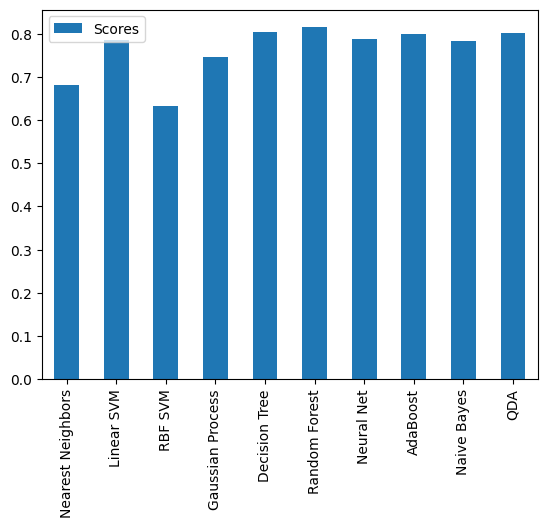

In [71]:
%matplotlib inline
res.plot(kind='bar', rot=90)